Boost Converter Compensation Design
============================================

# Table of Contents

- [Initializations](#Initializations)
- [Prerequisites](#Prerequisites)
- [Specification](#Specification)
- [Compensator_Type_2](#Compensator_Type_2)
- [Open-loop_response](#Open-loop_response)
- [Op-amp_compensator_type_2](#Op-amp_compensator_type_2)
- [References](#References)

# Initializations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control as ct

import warnings
warnings.filterwarnings('ignore')

# Prerequisites

## Plant
Boost Converter Power Stage Transfer Function

Transfer function:

$$ H(s) = H_{DC}(s) H_P(s) H_Z(s) H_{RHPZ}(s) H_H(s) $$

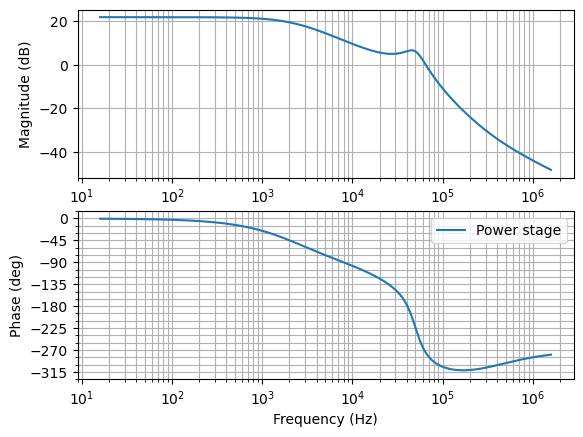

In [2]:
# PARAMETERS
H_DC_dB = 21.7                        # [dB], power stage DC gain
H_DC = np.power(10,H_DC_dB/20)
F_P = 2.33e3                          # [Hz], power stage low-frequency pole
omega_P = 2*np.pi*F_P
F_Z = 339e3                           # [Hz], output capacitor zero
omega_Z = 2*np.pi*F_Z
F_RHPZ = 34.7e3                       # [Hz], right half plane zero (in CCM)
omega_RHPZ = 2*np.pi*F_RHPZ
F_N = 50e3                            # [Hz], power stage high-frequency double poles
omega_N = 2*np.pi*F_N
Q_P = 1.99                            # Power stage high-frequency quality factor

# TRANSFER FUNCTION
s = ct.tf('s')
H_P = 1 / (1 + s/omega_P)                                    # Low-frequency transfer function
H_Z = 1 + s/omega_Z                                          # Output capacitor transfer function
H_RHPZ = 1 - s/omega_RHPZ                                    # Right half plane zero transfer function
H_H = 1 / (1 + s/(omega_N*Q_P) + (s/omega_N)*(s/omega_N))    # High-frequency transfer function
H = H_DC * H_P * H_Z * H_RHPZ * H_H                          # Power stage transfer function

# BODE PLOT
Gmag, Gphase, Gomega = ct.bode_plot(H, dB = True, Hz = True, omega_limits = [1e2, 1e7])
plt.legend(labels=('Power stage',))

# Specification
* -20 dB / decade at the crossover frequency.
* High-frequency pole to filter noise.

In [3]:
F_0db = 5e3            # [Hz], crossover frequency, requirement: F_0dB < min(F_SW/10, F_RHPZ/5)
F_Z = 1e3              # [Hz], zero, requirement: ~F_0db/5
omega_Z = 2*np.pi*F_Z
F_P = 34.7e3           # [Hz], second pole, requirement: ~min(F_Z, F_RHPZ)
omega_P = 2*np.pi*F_P

# Compensator_Type_2
Type 2: An Origin Pole, plus a Pole/Zero Pair

Transfer function:

$$ G(s) = -G_0 \frac{1 + \frac{\omega_Z}{s}}{1 + \frac{s}{\omega_P}} $$

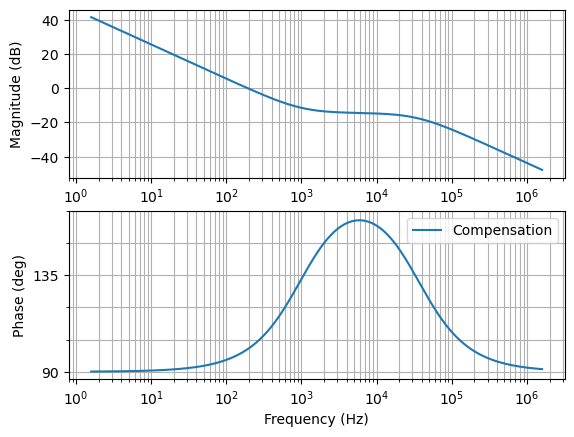

In [4]:
G_0_dB = -14.5                     # [dB], adjusted after magnitude at 0-dB-crossover 
                                   # frequency in open loop response bode plot below.
G_0 = np.power(10,G_0_dB/20)
G = -G_0 * (1+omega_Z/s) / (1+s/omega_P)
Gmag, Gphase, Gomega = ct.bode_plot(G, dB = True, Hz = True, omega_limits = [1e1, 1e7],
                                   initial_phase = 0)
plt.legend(labels=('Compensation',))

# Open-loop_response

Transfer function:

$$ H(s)G(s) $$

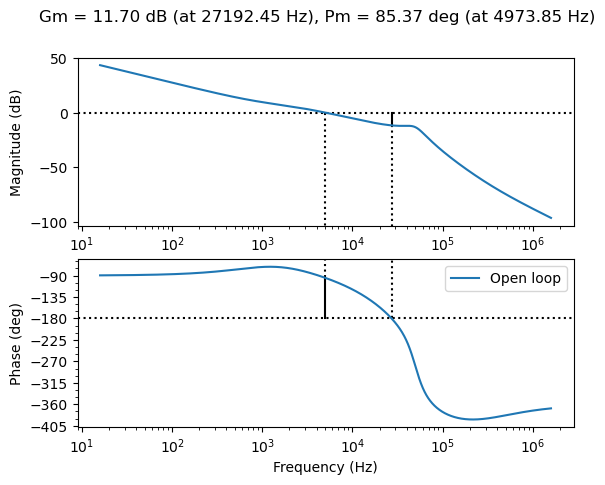

In [5]:
HG = H*G
Gmag, Gphase, Gomega = ct.bode_plot(-HG, dB = True, Hz = True, wrap_phase = False,
                                    omega_limits = [1e2, 1e7], margins = True,
                                   initial_phase = 0)
plt.legend(labels=('Open loop',))

In [6]:
#print("Gain at F_0db: {0:1.3g} (Shall be ~0 dB)".format(20*np.log10(abs(HG(2*np.pi*F_0db)))))
#gm, pm, wcg, wcp = ct.margin(HG)
#print("Gain margin = {0:1.3g}".format(gm))
#print("Phase margin = {0:1.3g}°".format(pm))
#print("Crossover frequency = {0:1.3g} Hz".format(wcg))


# Op-amp_compensator_type_2
Type 2: An Origin Pole, plus a Pole/Zero Pair

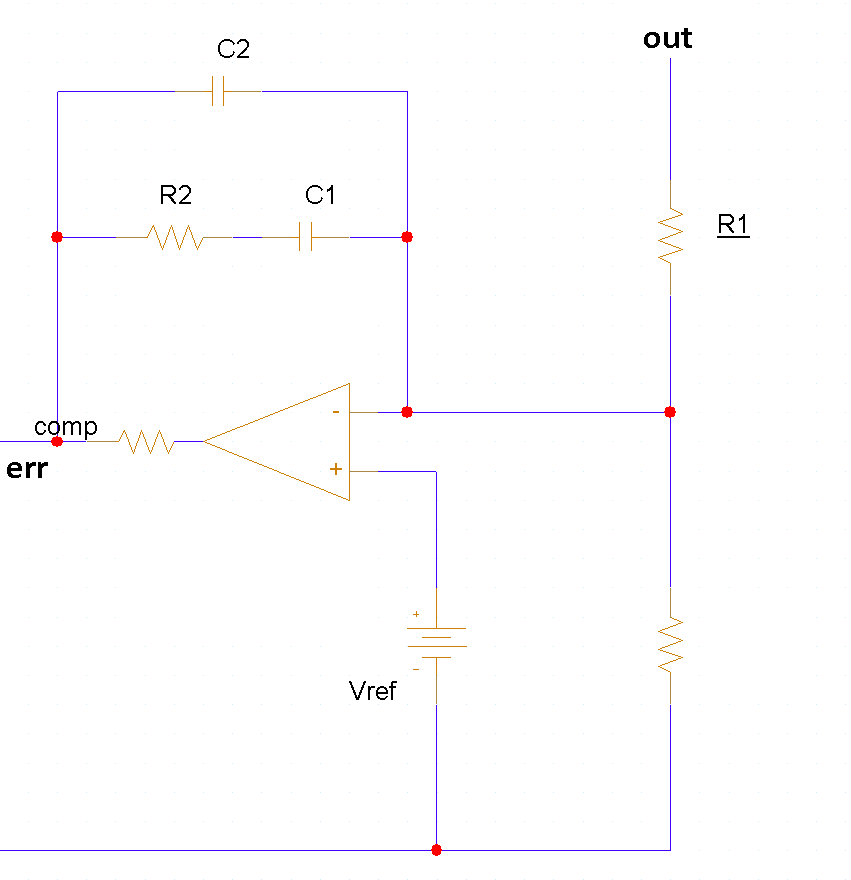


Transfer function:

$$ G(s) = -G_0 \frac{1 + \frac{\omega_Z}{s}}{1 + \frac{s}{\omega_P}} $$

where

$$ G_0 = \frac{R_2}{R_1} \frac{C_1}{C_1 + C_2} $$

$$ \omega_Z = \frac{1}{R_2 C_1} $$

$$ \omega_P = \frac{1}{R_2 \frac{C_1 C_2}{C_1+C_2}}$$png)

## Design

Resistor $R_1$ fixed and if $C_2 << C_1$: 

$$ R_2 = R_1 G_0$$

$$ C_2 = \frac{1}{R_2 \omega_P}$$

$$ C_1 = \frac{1}{R_2 \omega_Z}$$

where

$ G_0 = \frac{R_2}{R_1}$, $\omega_P = \frac{1}{R_2 C_2}$, $\omega_Z = \frac{1}{R_2 C_1}$


In [7]:
G_0 = G_0
R_1 = 10e3
print("R_1 = {0:1.3g}".format(R_1))
R_2 = R_1*G_0
print("R_2 = {0:1.3g}".format(R_2))
C_2 = 1 / (R_2*omega_P)
print("C_2 = {0:1.3g}".format(C_2))
C_1 = 1 / (R_2*omega_Z)
print("C_1 = {0:1.3g}".format(C_1))


R_1 = 1e+04
R_2 = 1.88e+03
C_2 = 2.43e-09
C_1 = 8.45e-08


# References
[TI_SLVA636] "Practical Feedback Loop Analysis for Current-Mode Boost Converter", Texas Instruments, March 2014

[BassoControlLoops] "Designing Control Loops for Linear and 
Switching Power Supplie", Christophe Basso, 2012s

[Control] "Python Control Systems Library", https://python-control.readthedocs.io/en/0.9.4/